## Imports

In [1]:
### --- MAIN LIBRARIES --- ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown

In [2]:
!pip install geoplot
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz
!pip install pyvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 30.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 30 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64

In [3]:
### --- GEO LIBRARIES --- ###

import geopandas as gpd
import geoplot as gplt
import plotly.graph_objects as go
import networkx as nx
import pygraphviz
from pyvis.network import Network

# Week 1

### Part 1

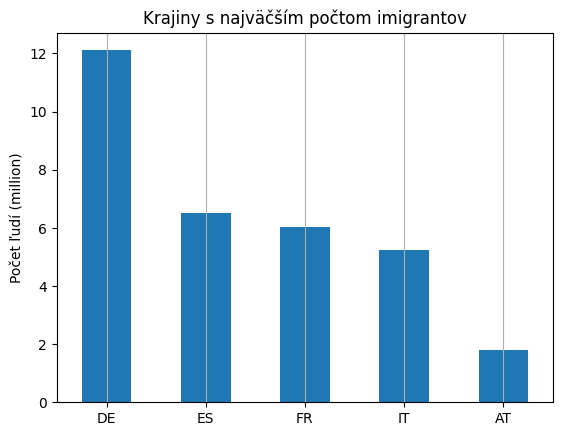

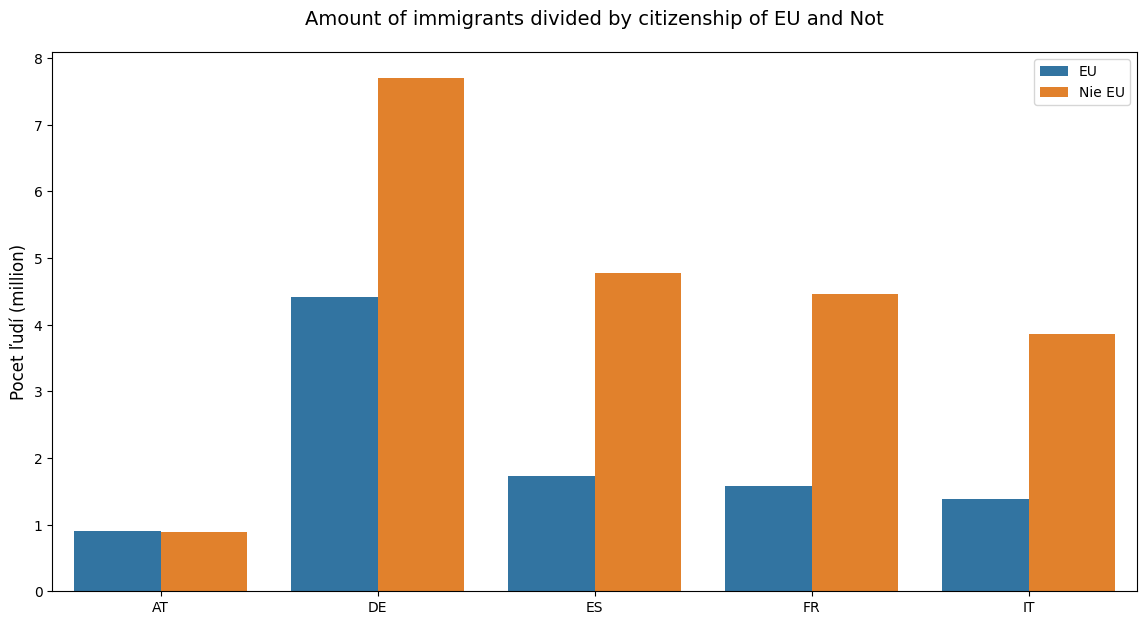

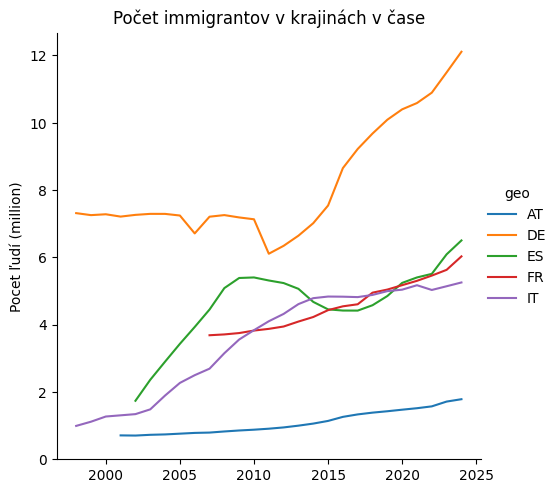

In [4]:
url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/GeneralEU1.csv"
urlEUandNot = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/MigratesFromEUandNot.csv"

df = pd.read_csv(url).drop(['STRUCTURE','STRUCTURE_ID', 'CONF_STATUS', 'OBS_FLAG', 'freq'], axis=1)

# ДатаФрейм без разделения полов
df_without_genders = (df.groupby(['geo', 'TIME_PERIOD'])['OBS_VALUE']
                      .sum()
                      .reset_index()
                      .assign(OBS_VALUE_milion = lambda df: df['OBS_VALUE']/ 1000000))


# ДатаФрейм отсортированный по кол-ву людей по убыванию
df_sorted_by_number_immigrates = df_without_genders[df_without_genders['TIME_PERIOD'] == 2024].sort_values(by="OBS_VALUE", ascending=False)
# Список, который содержит 5 стран с наибольшим кол-вом людей
countries_highest_number_immigrates = list(df_sorted_by_number_immigrates['geo'][:5])
# График людей 5 стран с наибольшим кол-вом людей за 2024 год
plot_for_number_immigrates = df_sorted_by_number_immigrates[:5].plot(x='geo',
                                                                     y='OBS_VALUE_milion',
                                                                     kind='bar',
                                                                     ylabel='Počet ľudí (million)',
                                                                     xlabel='',
                                                                     title='Krajiny s najväčším počtom imigrantov',
                                                                     legend=False)
plot_for_number_immigrates.set_xticklabels(df_sorted_by_number_immigrates[:5]['geo'], rotation=0)
plot_for_number_immigrates.grid(axis='x')

# График людей 5 стран с наибольшим кол-вом людей за 2024 год разделенный по ЕУ и нет
df2 = pd.read_csv(urlEUandNot).drop(['STRUCTURE','STRUCTURE_ID', 'CONF_STATUS', 'OBS_FLAG', 'freq', 'TIME_PERIOD'], axis=1)
df2['OBS_VALUE_milion'] = df2['OBS_VALUE'] /1000000
df_eu = df2.query('citizen=="EU27_2020_FOR"')
df_total = df2.query('citizen=="FOR_STLS"')
merged = pd.merge(
    df_total[['geo', 'OBS_VALUE_milion']],
    df_eu[['geo', 'OBS_VALUE_milion']],
    on=['geo'],
    suffixes=('_total', '_eu')
)
merged['OBS_VALUE_milion_not_eu'] = merged['OBS_VALUE_milion_total'] - merged['OBS_VALUE_milion_eu']
df_not_eu = merged[['geo', 'OBS_VALUE_milion_not_eu']].rename(columns={'OBS_VALUE_milion_not_eu': 'OBS_VALUE_milion'})
df_eu = df_eu.drop(['citizen', 'age', 'unit', 'sex', 'OBS_VALUE'], axis=1)
df_not_eu['category'] = 'Nie EU'
df_eu['category'] = 'EU'
df_not_and_from_eu = pd.concat([df_eu, df_not_eu], ignore_index=True)

fig, axes = plt.subplots(1, 1, figsize=(14, 7))

plot_for_number_immigrates_divided_by_EU = sns.barplot(data=df_not_and_from_eu[df_not_and_from_eu['geo'].isin(countries_highest_number_immigrates)],
                                                       x='geo', y='OBS_VALUE_milion', hue='category', ax=axes)
axes.set_title("Amount of immigrants divided by citizenship of EU and Not", fontsize=14, pad=20)
axes.set_xlabel("", fontsize=12)
axes.set_ylabel("Pocet ľudí (million)", fontsize=12)
axes.legend(title='')

# График как менялось кол-во людей для 5 стран с наибольшим кол-вом людей за 2024 год
plot_for_number_immigrates_trough_time = sns.relplot(data=df_without_genders[df_without_genders['geo'].isin(countries_highest_number_immigrates)],
                                                     x='TIME_PERIOD', y='OBS_VALUE_milion',
                                                     hue='geo', kind="line")
plot_for_number_immigrates_trough_time.set_axis_labels('', 'Pocet ľudí (million)')
plot_for_number_immigrates_trough_time.set(title='Počet immigrantov v krajinách v čase')
# Настройка, чтоб отсчет в графике был от нуля
plt.ylim(0, )

#Ще редагую -Н

plt.show()

In [5]:
url1 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/points_of_country.csv"
data_frame_by_points_of_country = pd.read_csv(url1).drop(['ISO-ALPHA-3','IOC', 'FIFA'], axis=1)
data = {
    "geo": list(df['geo'].unique())
}
data_frame_by_points_of_country = data_frame_by_points_of_country.iloc[:, :4]

nove = pd.DataFrame(data)
points = pd.merge(nove, data_frame_by_points_of_country, left_on='geo', right_on='ISO-ALPHA-2')
points = points.query('Country != "East Germany" and Country != "German Democratic Republic" and Country != "West Germany"')
points = points.drop_duplicates(subset=['ISO-ALPHA-2'], keep='first')
points = points.drop('ISO-ALPHA-2',axis=1)
nove_frame = pd.merge(points, df_sorted_by_number_immigrates, on="geo")



fig = px.scatter_geo(
    nove_frame,
    lat="Latitude",
    lon="Longitude",
    size="OBS_VALUE",
    hover_name="Country"
    )
fig.update_geos(
    projection_type="azimuthal equal area",
    lonaxis_range= [-20, 40],
    lataxis_range= [20, 70],
    showcountries = True
)
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


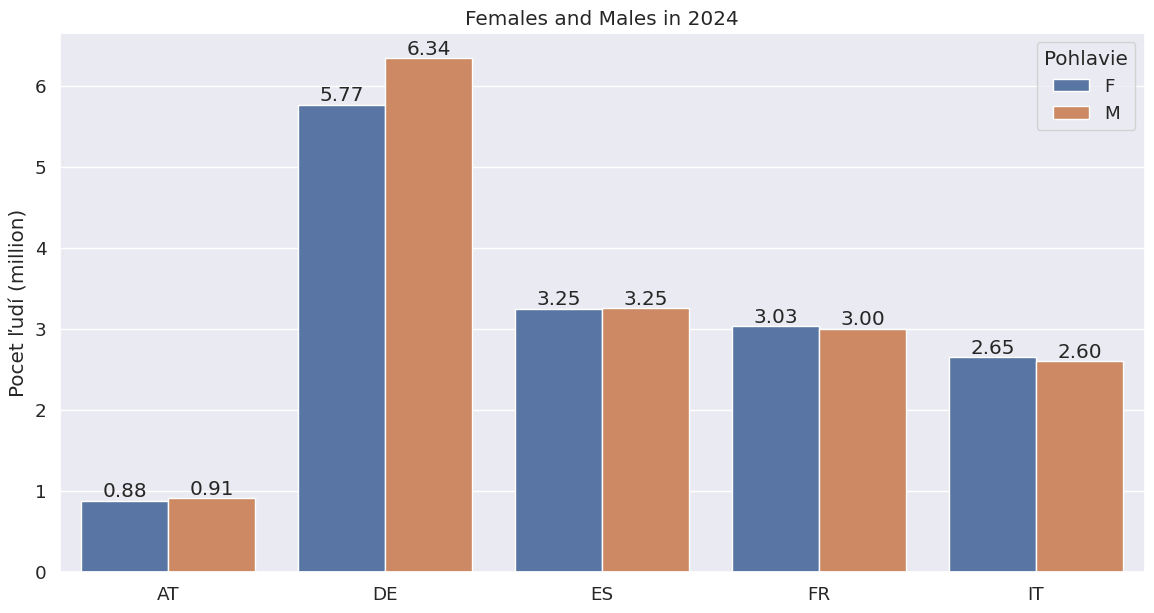

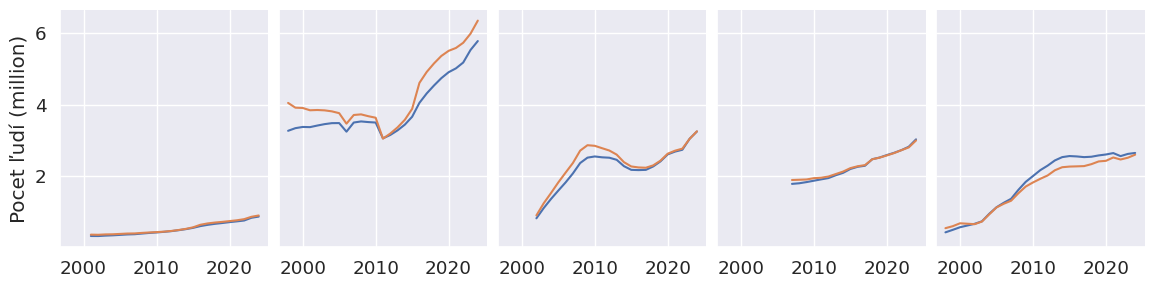

In [6]:
df['OBS_VALUE_milion'] = df['OBS_VALUE'] /1000000
osnova = df[df['geo'].isin(countries_highest_number_immigrates)]

#
df_males = (df[df['sex']=='M']
            .query('TIME_PERIOD==2024')
            .assign(OBS_VALUE_milion=lambda df: df['OBS_VALUE']/ 1000000)
            .sort_values(by='OBS_VALUE_milion'))

df_females = (df[df['sex']=='F']
              .query('TIME_PERIOD==2024')
              .assign(OBS_VALUE_milion=lambda df: df['OBS_VALUE']/ 1000000)
              .sort_values(by='OBS_VALUE_milion'))

df_females = df_females[df_females['geo'].isin(countries_highest_number_immigrates)]
df_males = df_males[df_males['geo'].isin(countries_highest_number_immigrates)]

df_spolu = pd.merge(df_females,df_males, on='geo')

# Код між # не використовується, хз чи треба видаляти ^^^^

sns.set_theme(font_scale=1.2)
fig, axes = plt.subplots(figsize=(14, 7))

barplot = sns.barplot(data=osnova.query("TIME_PERIOD == 2024"),
            x='geo', y='OBS_VALUE_milion', hue='sex', ax=axes)
axes.set_ylabel('Pocet ľudí (million)')
axes.set_xlabel(None)
axes.set_title('Females and Males in 2024')
for container in barplot.containers:
    axes.bar_label(container, fmt='%.2f')
axes.legend(title='Pohlavie')

grid = sns.relplot(data=osnova, x='TIME_PERIOD', y='OBS_VALUE_milion',
                   col='geo', col_wrap=5, kind="line", height=3,
                   aspect=1,hue='sex')

grid.set_axis_labels('', 'Pocet ľudí (million)')
grid.set_titles('') #"{col_name}"
# Зафігачив, аби обидва плоти були одного розміру
grid.figure.set_size_inches(12.18, 4)
grid.figure.subplots_adjust(wspace=0.05,)
grid._legend.remove()

#Редагував для читабельності, оптимізував +стилізація
# -Н


plt.show()
pass

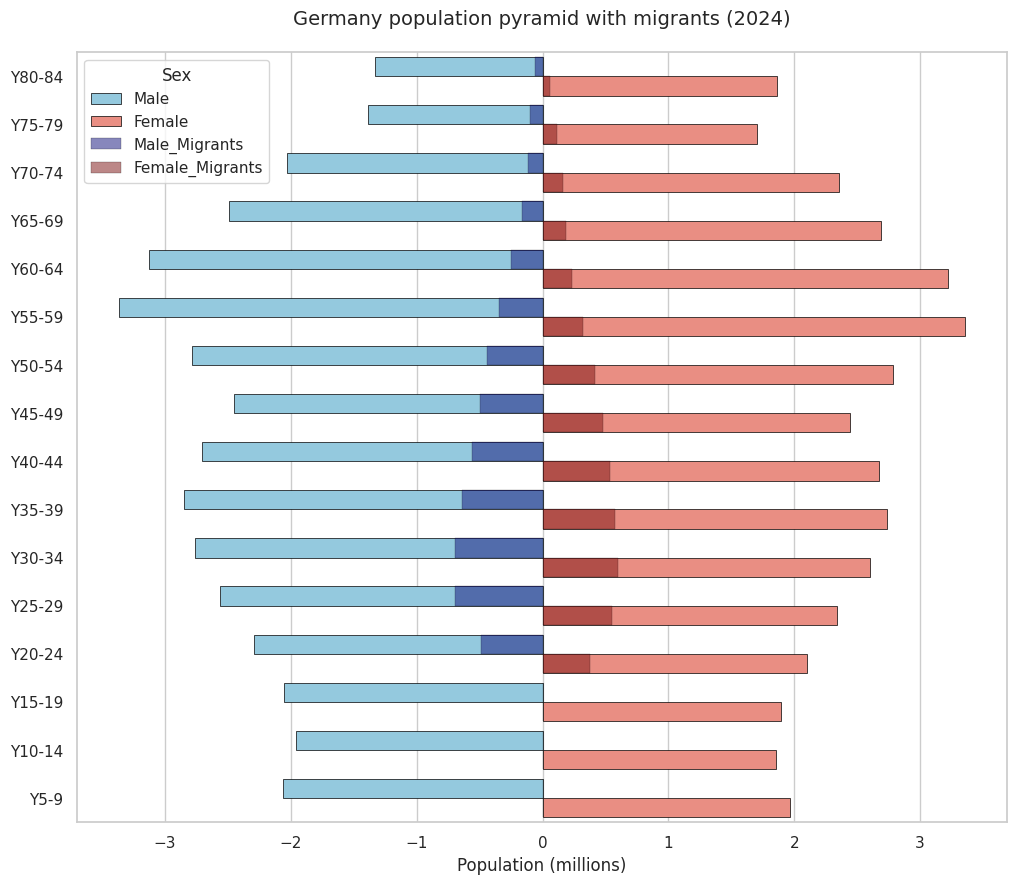

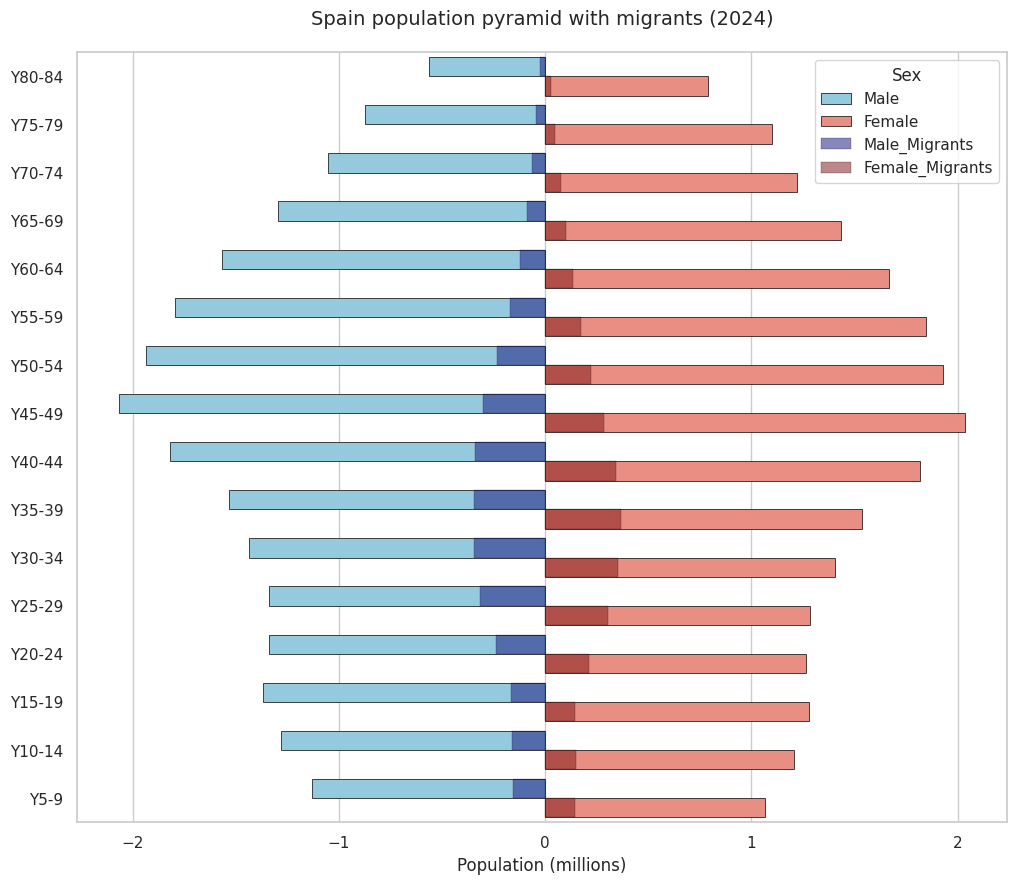

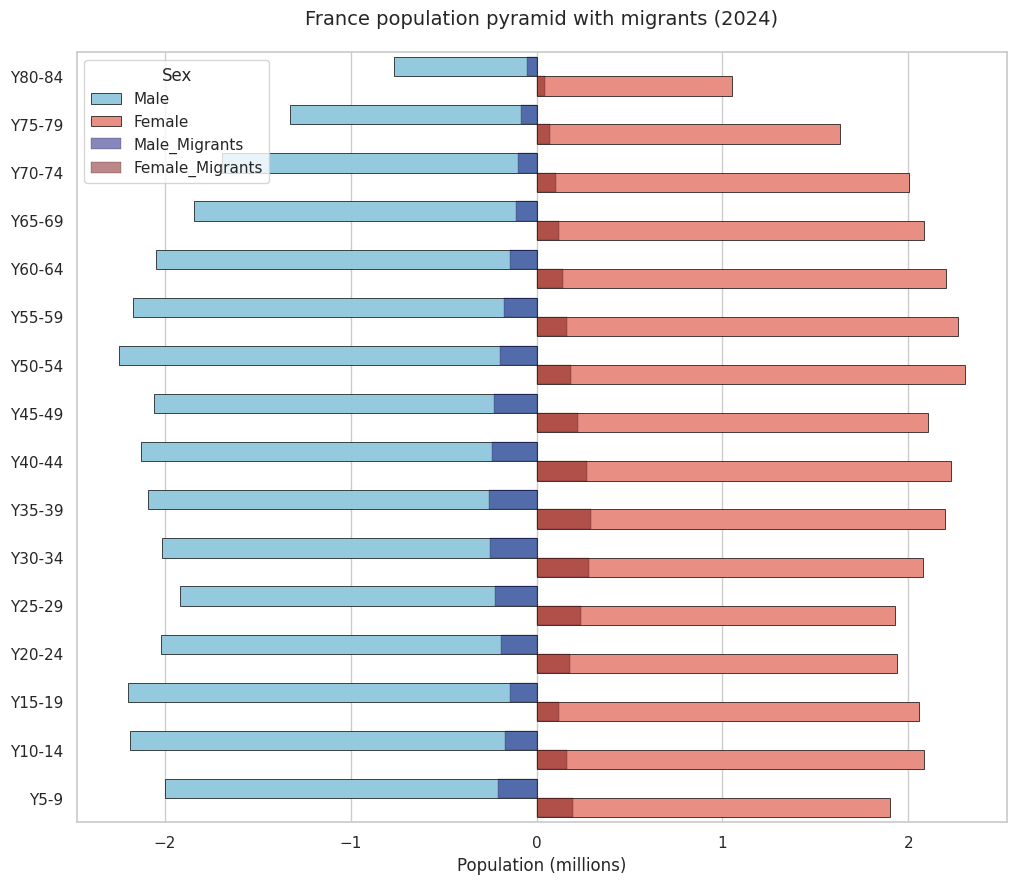

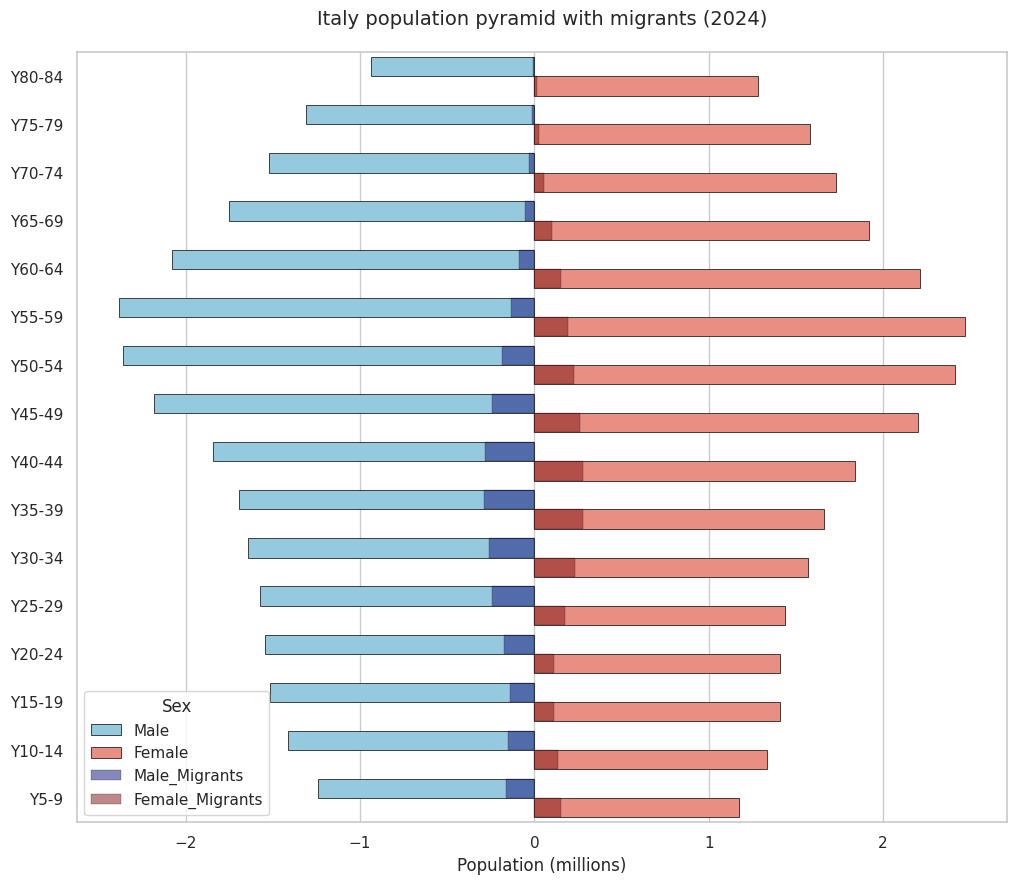

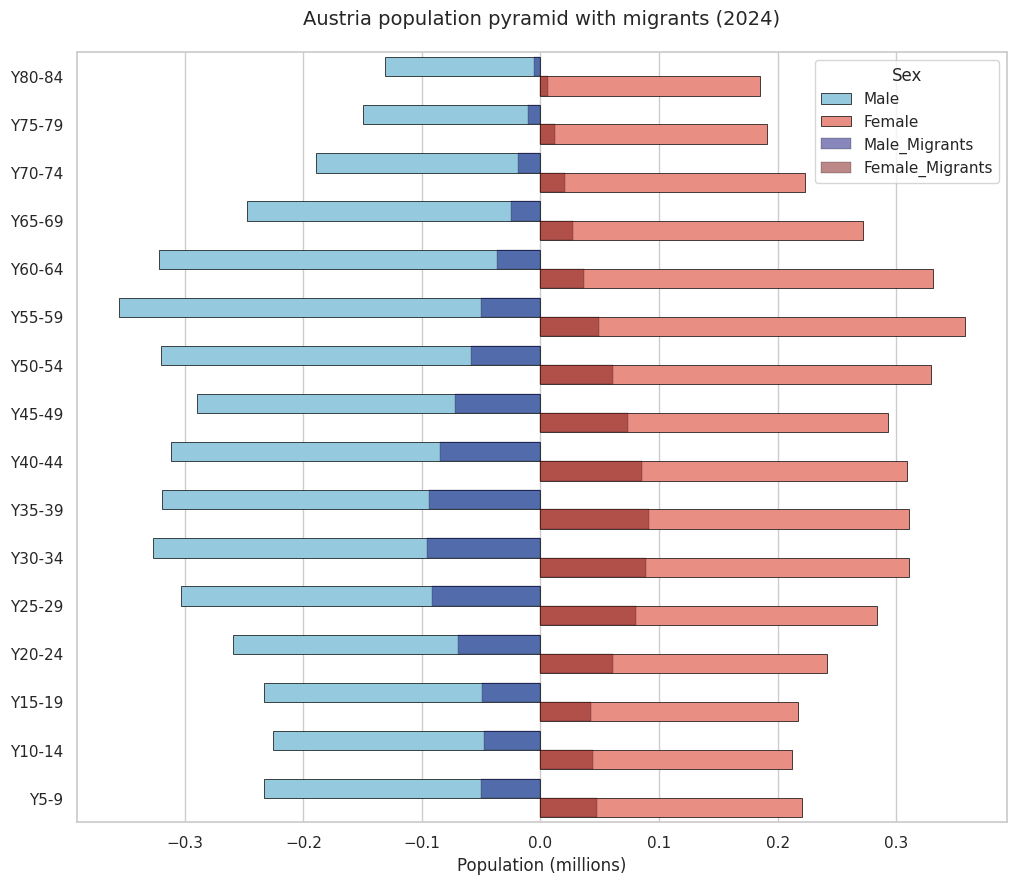

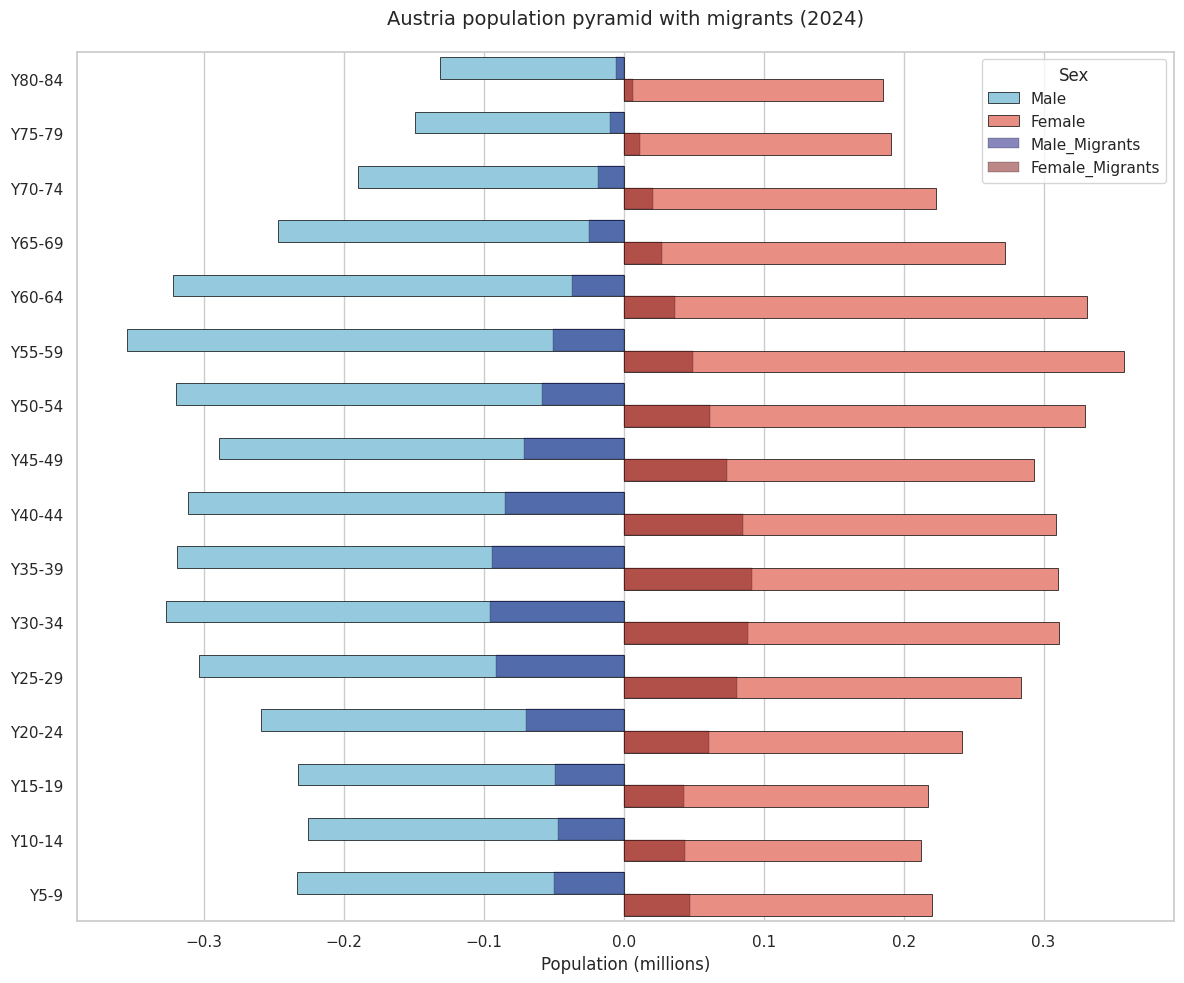

In [7]:
urlDemo = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/ForDemoPiramid.csv"

df_for_demo_piramids = pd.read_csv(urlDemo).drop(['STRUCTURE','STRUCTURE_ID', 'CONF_STATUS', 'OBS_FLAG', 'freq', 'TIME_PERIOD', 'unit'], axis=1)

def draw_piramid(name, short_name, df_for_demo_piramids):
  age_order=['Y80-84',
  'Y75-79',
  'Y70-74',
  'Y65-69',
  'Y60-64',
  'Y55-59',
  'Y50-54',
  'Y45-49',
  'Y40-44',
  'Y35-39',
  'Y30-34',
  'Y25-29',
  'Y20-24',
  'Y15-19',
  'Y10-14',
  'Y5-9']
  df_for_demo_piramids_M_total = df_for_demo_piramids.query('sex=="M"').query('geo==@short_name').query('citizen=="TOTAL"')
  df_for_demo_piramids_M_total['OBS_VALUE_milion'] = -df_for_demo_piramids_M_total['OBS_VALUE']/1000000
  df_for_demo_piramids_M_total = df_for_demo_piramids_M_total.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Male'}).rename(columns={'age': 'Age'})

  df_for_demo_piramids_F_total = df_for_demo_piramids.query('sex=="F"').query('geo==@short_name').query('citizen=="TOTAL"')
  df_for_demo_piramids_F_total['OBS_VALUE_milion'] = df_for_demo_piramids_F_total['OBS_VALUE']/1000000
  df_for_demo_piramids_F_total = df_for_demo_piramids_F_total.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Female'}).rename(columns={'age': 'Age'})


  df_for_demo_piramids_M_migr = df_for_demo_piramids.query('sex=="M"').query('geo==@short_name').query('citizen=="FOR_STLS"')
  df_for_demo_piramids_M_migr['OBS_VALUE_milion'] = -df_for_demo_piramids_M_migr['OBS_VALUE']/1000000
  df_for_demo_piramids_M_migr = df_for_demo_piramids_M_migr.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Male_Migrants'}).rename(columns={'age': 'Age'})
  if short_name == 'DE':
    missing_ages = ["Y5-9", "Y10-14", "Y15-19"]
    df_missing = pd.DataFrame({
        'Age': missing_ages,
        'Male_Migrants': 0.0
    })
    df_for_demo_piramids_M_migr = pd.concat([
        df_for_demo_piramids_M_migr,
        df_missing
    ], ignore_index=True)

  df_for_demo_piramids_F_migr = df_for_demo_piramids.query('sex=="F"').query('geo==@short_name').query('citizen=="FOR_STLS"')
  df_for_demo_piramids_F_migr['OBS_VALUE_milion'] = df_for_demo_piramids_F_migr['OBS_VALUE']/1000000
  df_for_demo_piramids_F_migr = df_for_demo_piramids_F_migr.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Female_Migrants'}).rename(columns={'age': 'Age'})
  if short_name == 'DE':
    missing_ages = ["Y5-9", "Y10-14", "Y15-19"]
    df_missing = pd.DataFrame({
        'Age': missing_ages,
        'Female_Migrants': 0.0
    })
    df_for_demo_piramids_F_migr = pd.concat([
        df_for_demo_piramids_F_migr,
        df_missing
    ], ignore_index=True)

  df_for_demo_piramids_total = pd.merge(df_for_demo_piramids_M_total, df_for_demo_piramids_F_total, on='Age')
  df_for_demo_piramids_migr = pd.merge(df_for_demo_piramids_M_migr, df_for_demo_piramids_F_migr, on='Age')
  df_for_demo_piramids = pd.merge(df_for_demo_piramids_total, df_for_demo_piramids_migr, on='Age')

  sns.set_theme(style="whitegrid")
  plt.figure(figsize=(12, 10))

  sns.barplot(
      data=df_for_demo_piramids.melt(id_vars="Age", value_vars=["Male", "Female"], var_name="Sex", value_name="Population"),
      y="Age",
      x="Population",
      hue="Sex",
      order=age_order,
      palette={"Male": "skyblue", "Female": "salmon"},
      edgecolor="black",
      linewidth=0.5,
  )

  sns.barplot(
      data=df_for_demo_piramids.melt(id_vars="Age", value_vars=["Male_Migrants", "Female_Migrants"], var_name="Sex", value_name="Migrants"),
      y="Age",
      x="Migrants",
      hue="Sex",
      order=age_order,
      palette={"Male_Migrants": "darkblue", "Female_Migrants": "darkred"},
      alpha=0.5,
      edgecolor="black",
      linewidth=0.3,
  )

  plt.title(name + " population pyramid with migrants (2024)", fontsize=14, pad=20)
  plt.xlabel("Population (millions)")
  plt.ylabel("")



#GERMANY
draw_piramid('Germany', 'DE', df_for_demo_piramids)
#GERMANY

#SPAIN
draw_piramid('Spain', 'ES', df_for_demo_piramids)
#SPAIN

#FRANCE
draw_piramid('France', 'FR', df_for_demo_piramids)
#FRANCE

#ITALY
draw_piramid('Italy', 'IT', df_for_demo_piramids)
#ITALY

#AUSTRIA
draw_piramid('Austria', 'AT', df_for_demo_piramids)
#AUSTRIA
draw_piramid('Austria', 'AT', df_for_demo_piramids)
plt.tight_layout()
plt.show()

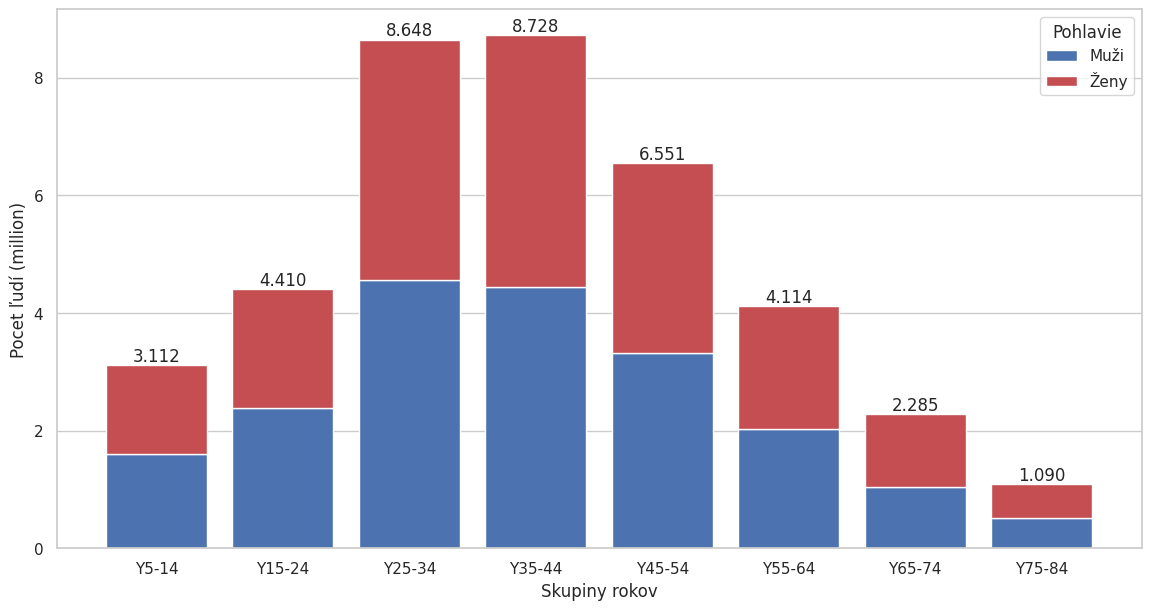

In [8]:
url2 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/age_data_2.csv"

# df_by_ages_in_2024 = pd.read_csv(url2).drop(['STRUCTURE', 'STRUCTURE_ID', 'freq', 'unit', 'OBS_FLAG', 'CONF_STATUS', 'geo', 'citizen'], axis=1).query('sex=="T" & TIME_PERIOD==2024')

# df_by_ages_in_2024['OBS_VALUE_milion'] = df_by_ages_in_2024['OBS_VALUE'] /1000000
# df_by_ages_in_2024 = df_by_ages_in_2024.groupby(['age'])['OBS_VALUE_milion'].sum().reset_index()
# df_by_ages_in_2024  = df_by_ages_in_2024.query('age!="Y15-64"').iloc[:-3,:].sort_values(by='age')

# df_by_ages_in_2024 = pd.concat([df_by_ages_in_2024.query('age == "Y5-9"'), df_by_ages_in_2024[df_by_ages_in_2024['age'] != 'Y5-9']])

# for i in range(5, 80, 10):
#   df_by_ages_in_2024.iloc[int(i/5-1), 0] = f'Y{i}-{i+9}'
#   df_by_ages_in_2024.iloc[int(i/5), 0] = f'Y{i}-{i+9}'

# df_by_ages_in_2024 = df_by_ages_in_2024.groupby(by=['age'])['OBS_VALUE_milion'].sum().reset_index()
# df_by_ages_in_2024 = pd.concat([df_by_ages_in_2024.query('age == "Y5-14"'), df_by_ages_in_2024[df_by_ages_in_2024['age'] != 'Y5-14']])

# fig, axes = plt.subplots(figsize=(14, 7))
# sns.barplot(data=df_by_ages_in_2024, x='age', y='OBS_VALUE_milion', color="C0", ax=axes)
# axes.set_ylabel('Pocet ľudí (million)')
# axes.set_xlabel(None)
# axes.set_title('Ages')

#Согл, так краще  ^^^ Лише трохи підправив
#Додав 'stack-овість', думаю інформативніше буде
#   -Нікіта

df_by_ages_gender = (pd.read_csv(url2)
                    .drop(['STRUCTURE', 'STRUCTURE_ID', 'freq', 'unit', 'OBS_FLAG', 'CONF_STATUS', 'geo', 'citizen'], axis=1)
                    .query('TIME_PERIOD == 2024 & sex != "T"')
                    .assign(OBS_VALUE_milion=lambda df: df['OBS_VALUE'] / 1000000)
                    .groupby(['age', 'sex'])['OBS_VALUE_milion']
                    .sum()
                    .reset_index())

df_by_ages_gender  = (df_by_ages_gender
                      .query('age!="Y15-64"').iloc[:-6,:]
                      .sort_values(by='age'))

df_by_ages_gender = pd.concat([df_by_ages_gender.query('age == "Y5-9"'),
                               df_by_ages_gender[df_by_ages_gender['age'] != 'Y5-9']])

df_by_ages_gender_men = df_by_ages_gender.query('sex == "M"')
df_by_ages_gender_women = df_by_ages_gender.query('sex == "F"')

for i in range(5, 80, 10):
  df_by_ages_gender_men.iloc[int(i/5-1), 0] = f'Y{i}-{i+9}'
  df_by_ages_gender_men.iloc[int(i/5), 0] = f'Y{i}-{i+9}'
  df_by_ages_gender_women.iloc[int(i/5-1), 0] = f'Y{i}-{i+9}'
  df_by_ages_gender_women.iloc[int(i/5), 0] = f'Y{i}-{i+9}'

df_by_ages_gender = pd.concat([df_by_ages_gender_men, df_by_ages_gender_women])

df_by_ages_gender = (df_by_ages_gender
                     .groupby(by=['age', 'sex'])['OBS_VALUE_milion']
                     .sum()
                     .reset_index())
df_by_ages_gender = pd.concat([df_by_ages_gender.query('age == "Y5-14"'),
                               df_by_ages_gender[df_by_ages_gender['age'] != 'Y5-14']])

df_by_ages_gender_men = df_by_ages_gender.query('sex == "M"')
df_by_ages_gender_women = df_by_ages_gender.query('sex == "F"')

fig, axes = plt.subplots(figsize=(14, 7))

male_plot = axes.bar(df_by_ages_gender_men['age'], df_by_ages_gender_men['OBS_VALUE_milion'],
                     color='b',)
female_plot = axes.bar(df_by_ages_gender_women['age'], df_by_ages_gender_women['OBS_VALUE_milion'],
                       bottom=df_by_ages_gender_men['OBS_VALUE_milion'], color='r')

axes.set_ylabel('Pocet ľudí (million)')
axes.set_xlabel('Skupiny rokov')
axes.grid(False, axis='x')
axes.legend(["Muži", "Ženy"], title='Pohlavie', loc="upper right")
axes.bar_label(female_plot, fmt='%.3f')

pass

### Part 2

In [ ]:
### --- DATA LOADING --- ###
def load_migration_data(filename):
    """Load and clean Eurostat migration data"""

    # Read CSV file
    df = pd.read_csv(filename)

    # Clean column names
    df = df.rename(columns={'geo\\TIME_PERIOD': 'country'})

    # Convert wide format to long format
    years = [col for col in df.columns if col.isdigit()]
    long_df = pd.melt(
        df,
        id_vars=['country', 'citizen', 'age', 'sex'],
        value_vars=years,
        var_name='year',
        value_name='count'
    )

    # Clean data
    long_df = long_df[
        (long_df['age'] == 'TOTAL') &
        (long_df['sex'] == 'T') &
        (long_df['citizen'] == 'TOTAL')
    ]

    # Convert types
    long_df['year'] = long_df['year'].astype(int)
    long_df['count'] = pd.to_numeric(
        long_df['count'].replace(':', pd.NA),
        errors='coerce'
    )

    return long_df

# Load both datasets
immigration = load_migration_data('data/migr_imm1ctz.csv')
emigration = load_migration_data('data/migr_emi1ctz.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/migr_imm1ctz.csv'

In [ ]:
### --- DATA MERGE --- ###
migration_data = pd.merge(
    immigration.rename(columns={'count': 'immigrants'}),
    emigration.rename(columns={'count': 'emigrants'}),
    on=['country', 'year'],
    how='outer'
)

# Filter for target countries
target_countries = ['SK', 'AT', 'HU', 'CZ']  # Slovakia, Austria, Hungary, Czechia
migration_data = migration_data[migration_data['country'].isin(target_countries)]

# Fill missing values with 0
migration_data = migration_data.fillna(0)

NameError: name 'immigration' is not defined

In [ ]:
### --- Slovakia Migration Plot --- ###
def plot_slovakia_migration():
    """Migration plot"""

    # Load and prepare data
    sk_data = migration_data[migration_data['country'] == 'SK'].copy()

    # Aggregate duplicate years and sort
    sk_data = sk_data.groupby('year', as_index=False).agg({
        'immigrants': 'sum',
        'emigrants': 'sum'
    }).sort_values('year').reset_index(drop=True)

    # Create figure
    plt.figure(figsize=(18, 9))
    ax = plt.gca()

    # Visual parameters
    bar_width = 0.4
    years = sk_data['year'].astype(int)
    x_pos = np.arange(len(years))
    color_imm = '#3498db'
    color_emi = '#e74c3c'

    # Plot bars
    ax.bar(x_pos - bar_width/2, sk_data['immigrants'], bar_width,
          label='Immigrants', color=color_imm, edgecolor='white')
    ax.bar(x_pos + bar_width/2, sk_data['emigrants'], bar_width,
          label='Emigrants', color=color_emi, edgecolor='white')

    # Configure x-axis (5-year intervals)
    xtick_labels = [str(y) if y%5 == 0 else '' for y in years]
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

    # Find peak values
    max_imm = sk_data['immigrants'].max()
    max_imm_year = sk_data.loc[sk_data['immigrants'].idxmax(), 'year']
    max_emi = sk_data['emigrants'].max()
    max_emi_year = sk_data.loc[sk_data['emigrants'].idxmax(), 'year']

    # Calculate positions
    imm_idx = sk_data['immigrants'].idxmax()
    emi_idx = sk_data['emigrants'].idxmax()
    imm_x = x_pos[imm_idx] - bar_width/2
    emi_x = x_pos[emi_idx] + bar_width/2

    # Vertical spacing parameters
    y_gap = max(max_imm, max_emi) * 0.18  # 18% of max value

    # Immigration annotation
    ax.annotate(f' Immigration Peak\n{int(max_imm):,} ({max_imm_year})',
                xy=(imm_x, max_imm),
                xytext=(imm_x, max_imm + y_gap*1.4),
                arrowprops=dict(arrowstyle='->', lw=1.5, color=color_imm,
                                connectionstyle='angle3,angleA=0,angleB=90'),
                ha='center', va='bottom', fontsize=12, color=color_imm,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=color_imm, alpha=0.9))

    # Emigration annotation
    ax.annotate(f' Emigration Peak\n{int(max_emi):,} ({max_emi_year})',
                xy=(emi_x, max_emi),
                xytext=(emi_x, max_emi + y_gap*1.8),
                arrowprops=dict(arrowstyle='->', lw=1.5, color=color_emi,
                                connectionstyle='angle3,angleA=0,angleB=90'),
                ha='center', va='bottom', fontsize=12, color=color_emi,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=color_emi, alpha=0.9))

    # Formatting
    ax.set_title('Slovakia Migration Trends with Highlighted Peaks', fontsize=18, pad=25)
    ax.set_xlabel('Year (5-year intervals)', fontsize=14, labelpad=15)
    ax.set_ylabel('Number of People', fontsize=14, labelpad=15)
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    ax.legend(frameon=True, fontsize=12, loc='upper left')

    # Set axis limits
    ax.set_ylim(top=max(max_imm, max_emi)*1.45)
    ax.set_xlim(-0.5, len(years)-0.5)

    # Remove spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_slovakia_migration()

NameError: name 'migration_data' is not defined

In [ ]:
### --- Neighboring Countries Comparison --- ###
def plot_neighbor_comparison():
    """Compare migration in neighboring countries"""

    # Prepare data
    recent_data = migration_data[migration_data['year'] >= 2018]
    countries = {
        'SK': 'Slovakia',
        'AT': 'Austria',
        'HU': 'Hungary',
        'CZ': 'Czechia'
    }

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot each country
    for i, (code, name) in enumerate(countries.items()):
        country_data = recent_data[recent_data['country'] == code]
        ax.plot(
            country_data['year'],
            country_data['immigrants'],
            marker='o',
            linestyle='--',
            label=f'{name} Immigration'
        )

    # Format plot
    ax.set_title('Immigration Trends in Central Europe (2018-2023)', pad=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Immigrants')
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_neighbor_comparison()

NameError: name 'migration_data' is not defined

In [ ]:
def analyze_migration_trends(data):
    """
    Analyze migration patterns for target countries
    Produces 4-panel visualization using seaborn
    """
    # Country code to name mapping
    COUNTRY_NAMES = {
        'SK': 'Slovakia',
        'AT': 'Austria',
        'HU': 'Hungary',
        'CZ': 'Czech Republic'
    }

    # Prepare data
    df = data.copy().replace({'country': COUNTRY_NAMES})
    df['net_migration'] = df['immigrants'] - df['emigrants']
    recent_years = df[df['year'] >= 2020]

    # Create figure
    plt.figure(figsize=(18, 14))
    plt.style.context('ggplot')

    # --- Panel 1: Migration Composition ---
    plt.subplot(2, 2, 1)
    ax1 = sns.barplot(
    x='year',
    y='value',
    hue='type',
    data=df.melt(
        id_vars=['country', 'year'],
        value_vars=['immigrants', 'emigrants'],
        var_name='type'
    ),
    palette={'immigrants': '#1f77b4', 'emigrants': '#ff7f0e'},
    errorbar=None
    )
    plt.title('Immigration vs Emigration Composition', pad=20)
    plt.xlabel('Year', labelpad=15)
    plt.ylabel('Number of People', labelpad=15)
    plt.legend(title='Flow Type', frameon=True)
    plt.xticks(rotation=45, ha='right')

    # Fix x-axis labels rotation
    plt.xticks(rotation=45, ha='right')

    # --- Panel 2: Net Migration Trends ---
    plt.subplot(2, 2, 2)
    for country in COUNTRY_NAMES.values():
        country_data = df[df['country'] == country]
        sns.lineplot(
            x='year',
            y='net_migration',
            data=country_data,
            label=country,
            marker='o',
            linewidth=2.5,
            markersize=10
        )
    plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
    plt.title('Net Migration Trends by Country', pad=20)
    plt.xlabel('Year', labelpad=15)
    plt.ylabel('Net Migration Balance', labelpad=15)
    plt.legend(frameon=True)

    # --- Panel 3: Country Comparison ---
    plt.subplot(2, 2, 3)
    ax3 = sns.boxplot(
        x='country',
        y='net_migration',
        hue='country',  # Added hue parameter
        data=df,
        palette='Set2',
        showmeans=True,
        meanprops={"marker":"D", "markerfacecolor":"white", "markersize":"10"},
        dodge=False,  # Disable dodge when using hue with same variable
        legend=False  # Disable redundant legend
    )
    plt.title('Net Migration Distribution (2010-2023)', pad=20)
    plt.xlabel('Country', labelpad=15)
    plt.ylabel('Net Migration', labelpad=15)
    plt.grid(axis='y', alpha=0.3)

    # Fix x-axis labels rotation
    plt.xticks(rotation=45, ha='right')

    # --- Panel 4: Recent Years Heatmap ---
    plt.subplot(2, 2, 4)
    heatmap_data = recent_years.pivot_table(
        index='country',
        columns='year',
        values='net_migration'
    )
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".0f",
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Net Migration'}
    )
    plt.title('Recent Migration Balance (2020-2023)', pad=20)
    plt.xlabel('Year', labelpad=15)
    plt.ylabel('Country', labelpad=15)

    plt.tight_layout(pad=3.0)
    plt.show()

# Run analysis
analyze_migration_trends(migration_data)

NameError: name 'migration_data' is not defined

In [ ]:
### --- Ukraine War Impact Analysis --- ###
def plot_ukraine_impact():
    """
    Analyze Ukrainian refugee impact in EU countries (2021-2023)
    Includes Slovakia and top 5 receiving nations
    """

    # Load and filter data
    ukr_raw = pd.read_csv('data/migr_imm1ctz.csv')
    ukr_data = ukr_raw.rename(columns={'geo\\TIME_PERIOD': 'country'})

    # Melt to long format
    years = [col for col in ukr_data.columns if col.isdigit()]
    ukr_long = pd.melt(
        ukr_data,
        id_vars=['country', 'citizen', 'age', 'sex'],
        value_vars=years,
        var_name='year',
        value_name='count'
    )

    # Clean and filter data
    ukr_clean = ukr_long[
        (ukr_long['citizen'] == 'UA') &
        (ukr_long['year'].between('2021', '2023')) &
        (ukr_long['age'] == 'TOTAL') &
        (ukr_long['sex'] == 'T')
    ].copy()

    # Convert types and handle missing values
    ukr_clean['year'] = ukr_clean['year'].astype(int)
    ukr_clean['count'] = pd.to_numeric(
        ukr_clean['count'].replace(':', 0),
        errors='coerce'
    ).fillna(0)

    # Prepare top countries including Slovakia
    top_countries = ukr_clean.groupby('country')['count'].sum().nlargest(5).index
    if 'SK' not in top_countries:
        top_countries = list(top_countries) + ['SK']

    # Create visualization
    plt.figure(figsize=(16, 8))

    # Plot grouped bars
    sns.barplot(
        data=ukr_clean[ukr_clean['country'].isin(top_countries)],
        x='year',
        y='count',
        hue='country',
        palette='tab10',
        estimator=sum,
        errorbar=None
    )

    # Formatting
    plt.title('Ukrainian Refugees in EU Countries (2021-2023)\nIncluding Slovakia Comparison',
             fontsize=18, pad=20)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Refugees', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Country', fontsize=12, title_fontsize=13,
              bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add value labels
    for p in plt.gca().patches:
        plt.gca().annotate(
            f'{int(p.get_height()):,}',
            (p.get_x() + p.get_width()/2, p.get_height()),
            ha='center', va='bottom', fontsize=10, xytext=(0, 5),
            textcoords='offset points'
        )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_ukraine_impact()

FileNotFoundError: [Errno 2] No such file or directory: 'data/migr_imm1ctz.csv'

In [ ]:
### --- Ukraine War Impact Analysis --- ###
def plot_ukraine_refugees():
    """Analyze Ukrainian refugee impact in EU countries (2021-2023) with map"""
    # Load and prepare data
    df = pd.read_csv('data/migr_imm1ctz.csv')
    df = df.rename(columns={'geo\\TIME_PERIOD': 'country_code'})

    # Country code to name mapping
    country_map = {
        'AT': 'Austria', 'BE': 'Belgium', 'BG': 'Bulgaria', 'CZ': 'Czechia',
        'DE': 'Germany', 'FR': 'France', 'HU': 'Hungary', 'IT': 'Italy',
        'PL': 'Poland', 'RO': 'Romania', 'SK': 'Slovakia', 'UA': 'Ukraine'
    }

    # Process data
    refugee_data = (
        pd.melt(df,
               id_vars=['country_code', 'citizen', 'age', 'sex'],
               value_vars=[col for col in df.columns if col.isdigit()],
               var_name='year',
               value_name='count')
        .query("citizen == 'UA' & year.between('2021', '2023')")
        .assign(
            year = lambda x: x['year'].astype(int),
            count = lambda x: pd.to_numeric(x['count'].replace(':', '0'), errors='coerce'),
            country = lambda x: x['country_code'].map(country_map)
        )
        .groupby(['country_code', 'country', 'year'])['count'].sum().reset_index()
    )

    # Get top countries including Slovakia
    top_countries = refugee_data.groupby('country_code')['count'].sum().nlargest(5).index
    if 'SK' not in top_countries:
        top_countries = list(top_countries) + ['SK']
    plot_data = refugee_data[refugee_data['country_code'].isin(top_countries)]

    # Create visualization
    fig = make_subplots(
        rows=2, cols=1,
        specs=[[{"type": "choropleth"}], [{"type": "bar"}]],
        vertical_spacing=0.1,
        subplot_titles=("Refugee Distribution in Europe", "Yearly Comparison")
    )

    # Map plot
    fig.add_trace(
        go.Choropleth(
            locations=plot_data['country'],
            z=plot_data['count'],
            locationmode='country names',
            colorscale='Oranges',
            marker_line_color='gray',
            colorbar_title='Refugees',
            hoverinfo='location+z',
            name=''
        ),
        row=1, col=1
    )

    # Bar chart
    for country in plot_data['country'].unique():
        country_df = plot_data[plot_data['country'] == country]
        fig.add_trace(
            go.Bar(
                x=country_df['year'],
                y=country_df['count'],
                name=country,
                showlegend=False
            ),
            row=2, col=1
        )

    # Layout settings
    fig.update_layout(
        template='plotly_white',
        height=800,
        margin={"r":20,"t":40,"l":20,"b":20},
        hoverlabel=dict(font_size=14)
    )

    # Europe map configuration
    fig.update_geos(
        resolution=50,
        scope="europe",
        center={"lat": 50, "lon": 15},
        projection_scale=2.3,
        showcountries=True,
        countrycolor="lightgray",
        showcoastlines=True,
        coastlinecolor="gray",
        showocean=True,
        oceancolor="azure",
        showframe=False
    )

    # Bar chart formatting
    fig.update_xaxes(title_text="Year", row=2, col=1)
    fig.update_yaxes(title_text="Number of Refugees", row=2, col=1)

    # Highlight Slovakia
    fig.for_each_trace(
        lambda trace: trace.update(marker_color='#2ca02c') if trace.name == 'Slovakia' else (),
    )

    return fig

plot_ukraine_refugees().show()

In [ ]:
### --- Covid Impact --- ###
def plot_covid_impact(data):
    """
    Analyze COVID-19 impacts with proper log scale handling
    """
    # Prepare data
    analysis_years = range(2018, 2024)
    region_data = data.groupby('year')['immigrants'].mean().reset_index()
    slovakia_data = data[data['country'] == 'SK'][['year', 'immigrants']]

    # Handle zero values for log scale
    region_data['immigrants'] = region_data['immigrants'].replace(0, 1)
    slovakia_data['immigrants'] = slovakia_data['immigrants'].replace(0, 1)

    # Calculate percentage changes
    pre_covid_reg = region_data[region_data['year'].between(2018, 2019)]['immigrants'].mean()
    covid_reg = region_data[region_data['year'].between(2020, 2021)]['immigrants'].mean()
    reg_change = ((covid_reg - pre_covid_reg) / pre_covid_reg) * 100

    pre_covid_sk = slovakia_data[slovakia_data['year'].between(2018, 2019)]['immigrants'].mean()
    covid_sk = slovakia_data[slovakia_data['year'].between(2020, 2021)]['immigrants'].mean()
    sk_change = ((covid_sk - pre_covid_sk) / pre_covid_sk) * 100

    # Create plot
    plt.figure(figsize=(12, 6))

    # Set logarithmic scale with proper formatting
    plt.yscale('log')

    # Plot trends with distinct markers
    sns.lineplot(x='year', y='immigrants', data=region_data,
                color='#1f77b4', marker='o', markersize=8,
                linewidth=2, label='Regional Average')
    sns.lineplot(x='year', y='immigrants', data=slovakia_data,
                color='#2ca02c', marker='s', markersize=6,
                linewidth=2, label='Slovakia')

    # Event markers
    plt.axvspan(2020, 2021, color='gray', alpha=0.2, label='COVID-19 Period')
    plt.axvline(2022, color='red', linestyle='--', alpha=0.7, label='War Start')

    # External annotations
    plt.annotate(f'Regional: {reg_change:+.1f}%',
                xy=(2021, region_data[region_data['year'] == 2021]['immigrants'].values[0]),
                xytext=(2023.2, region_data['immigrants'].max()),
                ha='left', va='top',
                color='#1f77b4',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='#1f77b4'),
                arrowprops=dict(arrowstyle='->', color='#1f77b4',
                              connectionstyle="arc3,rad=-0.2"))

    plt.annotate(f'Slovakia: {sk_change:+.1f}%',
                xy=(2021, slovakia_data[slovakia_data['year'] == 2021]['immigrants'].values[0]),
                xytext=(2023.2, slovakia_data['immigrants'].min()),
                ha='left', va='bottom',
                color='#2ca02c',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='#2ca02c'),
                arrowprops=dict(arrowstyle='->', color='#2ca02c',
                              connectionstyle="arc3,rad=0.2"))

    # Formatting
    plt.title('COVID-19 Impact Analysis (Log Scale)', fontsize=16, pad=20)
    plt.xlabel('Year', fontsize=12, labelpad=10)
    plt.ylabel('Immigration Count', fontsize=12, labelpad=10)
    plt.xticks(analysis_years, rotation=45, fontsize=10)
    plt.xlim(2017.8, 2023.5)

    # Proper log scale formatting
    plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter())
    plt.gca().yaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=5))
    plt.grid(alpha=0.3, which='both')
    plt.legend(frameon=True, loc='upper left')

    plt.tight_layout()
    plt.show()

plot_covid_impact(migration_data)